This notebook generates Figure 2 of Elipot et al. 2024 HYCOM-OceanTrack: Integrated HYCOM Eulerian Fields and Lagrangian Trajectories Dataset. It requires the calculated Lagrangian data density results.

In [23]:
# computational import
import numpy as np
import xarray as xr
import scipy.stats as stats

# file system import
import s3fs

# plotting import
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature

In [8]:
# open density datasets
dirin = '/Users/selipot/Data/faigle/aws_den/'
ds = {}
ds15 = {}
list11 = np.linspace(1,11,11)
for i in list11:
    ds[int(i)] = xr.open_dataset(dirin+'/hycom_aws_1o4_density_'+str(int(i))+'.nc')
    ds15[int(i)] = xr.open_dataset(dirin+'hycom_aws_1o4_density_'+str(int(i))+'_15m.nc')

In [25]:
# define bins
dxy = 0.25 
lon = np.arange(-180,180 + dxy, dxy)
lat = np.arange(-90, 90 + dxy, dxy)
dlon,dlat = np.meshgrid(lon,lat)

In [42]:
# calculate average density
for i in list11:
    if i == 1:
        den0 = ds[int(i)]['den']
        den15 = ds15[int(i)]['den']
# add steps together
    else:
        den0 = den0 + ds[int(i)]['den']
        den15 = den15 + ds15[int(i)]['den']

# average and convert to numpy for convenience
den0 = den0.to_numpy().T/11
den15 = den15.to_numpy().T/11

In [24]:
# We need to create a land mask to mask out the land points for the histogram calculation
# load the bathymetry 
# Access the data
bucket_name = 'hycom-global-drifters'
zarr_bathy_store_path = bucket_name+'/eulerian/hycom12_bathy.zarr'
s3 = s3fs.S3FileSystem(anon=True)
store0 = s3fs.S3Map(root=zarr_bathy_store_path, s3=s3)
ds_bathy = xr.open_zarr(store0, consolidated="auto").load()

# use scipy.binned_2dstat() to find min depth in each bin; bins with NaN will be land
min_bathy = stats.binned_statistic_2d(ds_bathy.Longitude.to_numpy().flatten(), 
                                ds_bathy.Latitude.to_numpy().flatten(),
                                ds_bathy.bathymetry.to_numpy().flatten(),
                                statistic = 'min',
                                bins= [lon,lat])
land_mask = np.isnan(min_bathy.statistic.T)
type(land_mask)


numpy.ndarray

In [26]:
# create a mask that combines land and latitudes between -70 and 75.25; the extremes of particle releases
count_mask = ~land_mask & (dlat[:-1,:-1] >= -70) & (dlat[:-1,:-1] <= 75.25)

In [94]:
# examine the range of values
p0 = np.percentile(den0[count_mask].flatten(),[0,1,50,99,100])
p15 = np.percentile(den15[count_mask].flatten(),[0,1,50,99,100])
print(p0)
print(p15)
print(p0[2]-p0[1],p0[2]-p0[3])
print(p15[2]-p15[1],p15[2]-p15[3])


[    0.           432.90909091  1424.27272727  1760.81818182
 23270.18181818]
[   0.           61.60636364 1426.72727273 1751.36363636 4228.45454545]
991.3636363636363 -336.5454545454545
1365.1209090909092 -324.6363636363635


In [66]:
n0, bins0 = np.histogram(den0[count_mask].flatten(),bins=np.arange(0,p0[4],24),density=False)
n15, bins15 = np.histogram(den15[count_mask].flatten(),bins=np.arange(0,p15[4],24),density=False)

In [29]:
# # create histograms to plot in subplot
# n, bins, patches = plt.hist(x = den[:,lat1:lat2].values.flatten(), bins = 100, histtype='stepfilled', 
#                             align = 'mid', density = True, range = (0,8000))
# n15, bins15, patches15 = plt.hist(x = den15[:,lat1:lat2].values.flatten(), bins = 100, histtype='stepfilled', 
#                             align = 'mid', density = True, range = (0,8000))


/var/folders/fx/qsnv05_94vs9qzp4p0qww8c00000gn/T/ipykernel_65523/3472266244.py:69: RuntimeWarning: divide by zero encountered in log10
  ax3.plot(bins_mean0, np.log10(n0), linestyle = '-',label='0 m')
/var/folders/fx/qsnv05_94vs9qzp4p0qww8c00000gn/T/ipykernel_65523/3472266244.py:72: RuntimeWarning: divide by zero encountered in log10
  ax3.plot(bins_mean15, np.log10(n15), linestyle = '-',label='15 m')


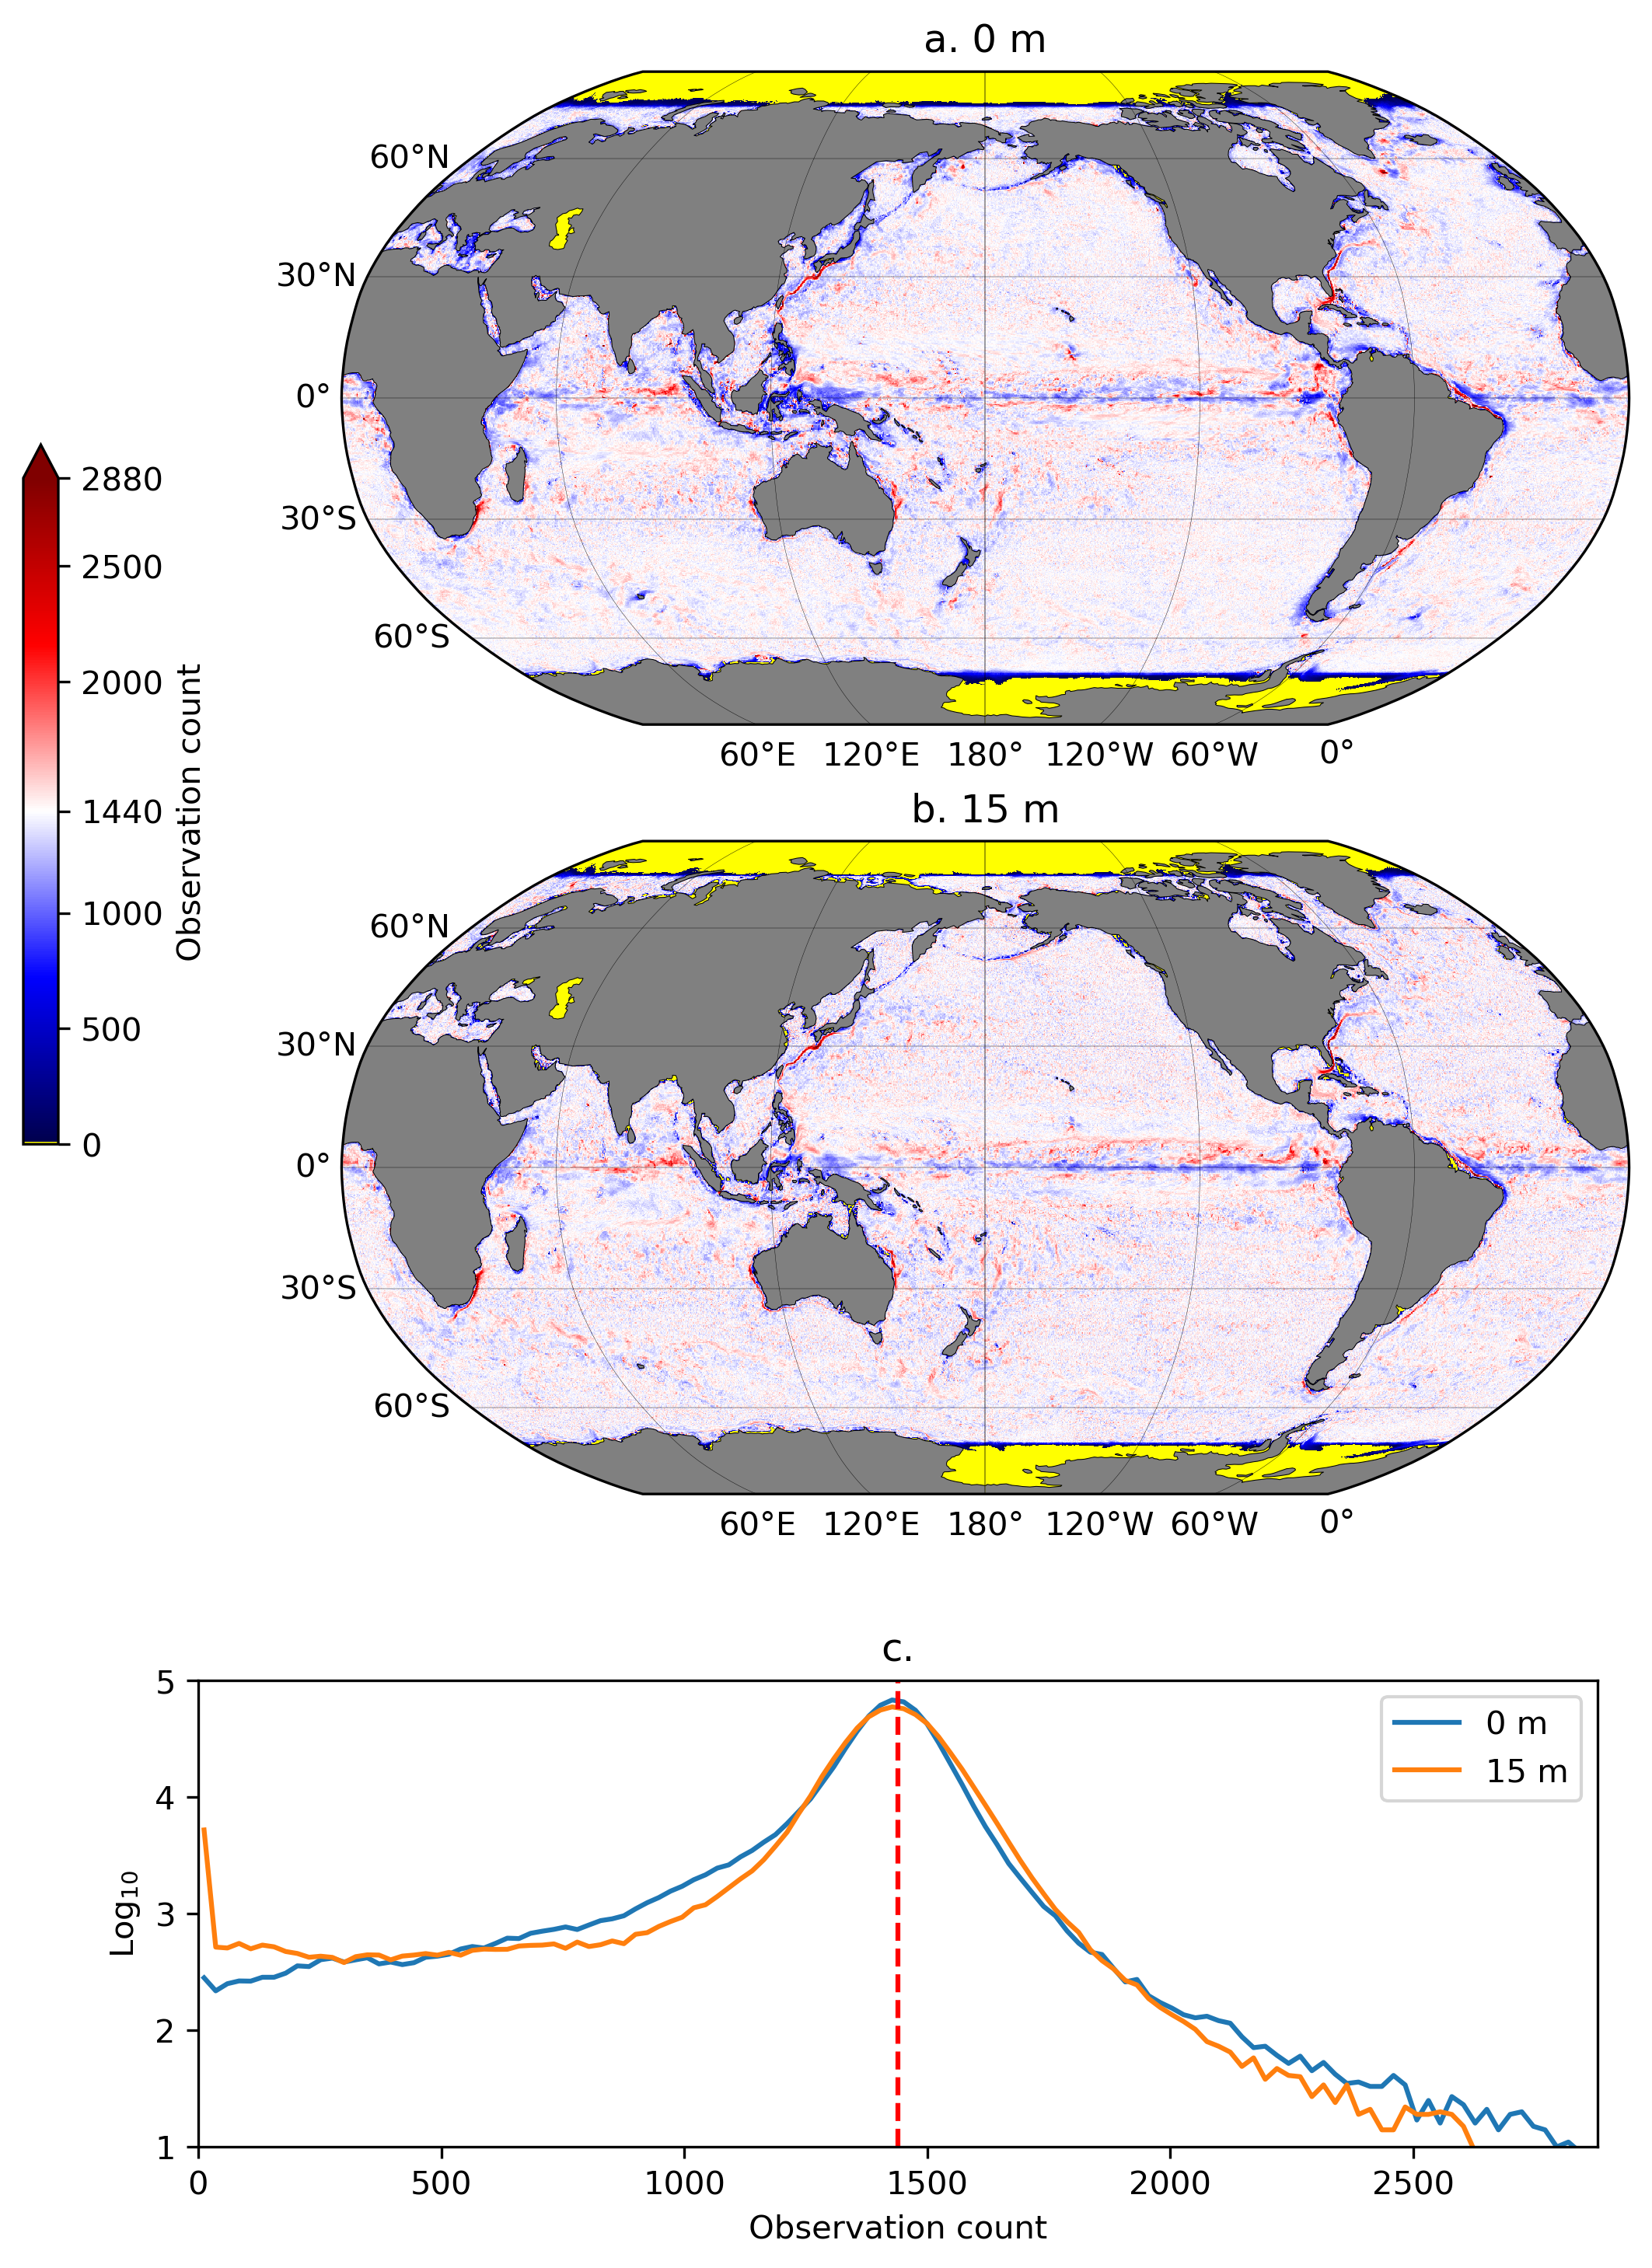

In [143]:
# set font size for lat/lon labels
#plt.rcParams.update({'font.size': 7, 'font.family': 'sans-serif'})
plt.rcParams.update({'font.size': 10})

# Create a colormap
cmap = plt.get_cmap('Spectral_r')
cmap = plt.get_cmap('seismic')

# Modify the colormap to set 0 to white
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (1, 1, 0, 1.0)  # Set the first color in the colormap to white
cmap = colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

cmax = 1440*2
cmin = 0

# create figure and image
fig = plt.figure(figsize = (7.5,10), dpi = 300)
ax1 = fig.add_subplot(3,1,1,projection=ccrs.Robinson(central_longitude=-180))
image = plt.pcolormesh(lon, lat, 
                den0,
                cmap=cmap, 
                transform=ccrs.PlateCarree(),
                vmin=cmin, vmax=cmax) 

# # gridlines and labels
gl = ax1.gridlines(color='k', linewidth=0.1, linestyle='-',
xlocs=np.arange(-180, 181, 60), ylocs=np.arange(-90, 91, 30),
draw_labels=True)
gl.bottom_labels = True
gl.right_labels = False
gl.top_labels = False

# add coastlines and land features
ax1.add_feature(cfeature.LAND, facecolor='grey', zorder=1)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)
ax1.set_title('a. 0 m')

ax2 = fig.add_subplot(3,1,2,projection=ccrs.Robinson(central_longitude=-180))
image = plt.pcolormesh(lon, lat, 
                den15,
                cmap=cmap, 
                transform=ccrs.PlateCarree(),
                vmin=cmin, vmax=cmax) 

# # gridlines and labels
gl = ax2.gridlines(color='k', linewidth=0.1, linestyle='-',
xlocs=np.arange(-180, 181, 60), ylocs=np.arange(-90, 91, 30),
draw_labels=True)
gl.bottom_labels = True
gl.right_labels = False
gl.top_labels = False

# add coastlines and land features
ax2.add_feature(cfeature.LAND, facecolor='grey', zorder=1)
ax2.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)
ax2.set_title('b. 15 m')

cbar_ax = fig.add_axes([0.05, 0.33+0.15, 0.02, 0.3]) # left, bottom, width, height
cb = fig.colorbar(image, cax=cbar_ax, orientation = "vertical", ticks = np.array([0,500,1000,1440,2000,2500,2880]), label = 'Observation count',extend = 'max')

cmap = plt.cm.viridis
# third subplot
ax3 = fig.add_subplot(3,1,3)

# take midpoint of bin to plot as x
bins_mean0 = [0.5 * (bins0[i] + bins0[i+1]) for i in range(len(n0))]
# plot x = midpoint of bin, y = normalized count
ax3.plot(bins_mean0, np.log10(n0), linestyle = '-',label='0 m')

bins_mean15 = [0.5 * (bins15[i] + bins15[i+1]) for i in range(len(n15))]
ax3.plot(bins_mean15, np.log10(n15), linestyle = '-',label='15 m')

ax3.set_title('c.')
# ax3.annotate("mean = "+str('{:04.3f}'.format((float(np.nanmean(den0))))), xy=(0.7,0.95),xycoords='axes fraction',
#              fontsize=7)
# ax3.annotate("median= "+str('{:04.3f}'.format((float(np.nanmedian(den0))))), xy=(0.7,0.9),xycoords='axes fraction',
#              fontsize=7)
# ax3.annotate("1% = "+str('{:04.3f}'.format((float(np.nanpercentile(den0, [1]))))), xy=(0.7,0.85),xycoords='axes fraction',
#              fontsize=7)
# ax3.annotate("99% = "+str('{:04.3f}'.format((float(np.nanpercentile(den0, [99]))))), xy=(0.7,0.8),xycoords='axes fraction',
#              fontsize=7)
# # mode = bin with highest count
# ax3.annotate("mode = "+str('{:04.3f}'.format((float(bins_mean[np.argmax(n0)])))), xy=(0.7,0.75),xycoords='axes fraction',
#              fontsize=7)
ax3.set_ylim(1,5)
ax3.axvline(x = 1440, color = 'r', linestyle = '--')
ax3.set_xlim((cmin,cmax))
ax3.set_xlabel('Observation count')
ax3.set_ylabel('Log$_{10}$')
ax3.legend()

# # fourth subplot
# ax4 = fig.add_subplot(2,2,4)

# # take midpoint of bin to plot as x
# bins_mean = [0.5 * (bins15[i] + bins15[i+1]) for i in range(len(n15))]
# # plot x = midpoint of bin, y = normalized count
# plt.plot(bins_mean, np.log10(n15), linestyle = '-')

# ax4.set_title('d. 15 m')
# # ax4.annotate("mean = "+str('{:04.3f}'.format((float(np.nanmean(den15))))), xy=(0.7,0.95),xycoords='axes fraction',
# #              fontsize=7)
# # ax4.annotate("median= "+str('{:04.3f}'.format((float(np.nanmedian(den15))))), xy=(0.7,0.9),xycoords='axes fraction',
# #              fontsize=7)
# # ax4.annotate("1% = "+str('{:04.3f}'.format((float(np.nanpercentile(den15, [1]))))), xy=(0.7,0.85),xycoords='axes fraction',
# #              fontsize=7)
# # ax4.annotate("99% = "+str('{:04.3f}'.format((float(np.nanpercentile(den15, [99]))))), xy=(0.7,0.8),xycoords='axes fraction',
# #              fontsize=7)
# # # mode = bin with highest count
# # ax4.annotate("mode = "+str('{:04.3f}'.format((float(bins_mean[np.argmax(n)])))), xy=(0.7,0.75),xycoords='axes fraction',
# #              fontsize=7)
# ax4.set_ylim(1,5)
# ax4.axvline(x = 1440, color = 'r', linestyle = '--')
# ax4.set_xlim((cmin,cmax))
# ax4.set_xlabel('Observation count')
# #ax4.set_ylabel('Log$_{10}$')


# Set positions for each subplot
ax1.set_position([0.1, 0.66, 1, 0.28])  # left, bottom, width, height
ax2.set_position([0.1, 0.33, 1, 0.28])
ax3.set_position([0.15, 0.05, 0.8, 0.2])
# ax4.set_position([0.57, 0.15, 0.4, 0.35])
plt.savefig('/Users/selipot/Work/manuscripts/tidaldrift/hycom-drifters/aws_density_sub.png', dpi = 300)